In [1]:
%matplotlib widget

import sys
import os.path as op
from glob import glob

import numpy as np
import scipy
from scipy.io import loadmat
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import mne
from mne.io import read_epochs_eeglab
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper
from mne.viz import plot_topomap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# set path to SpectralEvents
sys.path.append('/users/rthorpe/brainstorm-ws/spectral-events')
import spectralevents as se

import pdb

In [2]:
def read_data(subj_id, series_num, data_dir, pick_channels=None):
    # read in both pre- and post-TMS sessions belonging to a single subject
    series_num = str(series_num)
    subj_id = subj_id.zfill(4)
    fname_t1 = op.join(data_dir, 'series_' + series_num, 'T1/preprocessed',
                       subj_id + '_Pre_Session1_Series' + series_num + '_Preprocessed.set')
    fname_t2 = op.join(data_dir, 'series_' + series_num, 'T2/preprocessed',
                       subj_id + '_Post_Session1_Series' + series_num + '_Preprocessed.set')

    # read in data
    epochs_pre_post = list()
    for fname in [fname_t1, fname_t2]:
        epochs = read_epochs_eeglab(fname)
        if pick_channels is not None:
            epochs = epochs.pick_channels(pick_channels)
        epochs_data = epochs.get_data().squeeze()
        #epochs_data -= np.mean(epochs_data, axis=(1, 2), keepdims=True)
        #epochs_data /= np.std(epochs_data, axis=(1, 2), keepdims=True)
        epochs_pre_post.append(epochs_data)
    epochs_info = epochs.info  # save for fit_ssd()
    epoch_times = epochs.times  # save save for spec_event_coherence_shift()
    
    return epochs_pre_post, epochs_info, epoch_times


def plot_features_scatter(x, y, responder_labels, ax_labels):
    '''Plot features across subjects in a 2D scatter plot.'''
    g = sns.JointGrid()

    for class_idx, class_ in enumerate(set(responder_labels)):
        if class_ == 1:
            label = 'responders'
        else:
            label = 'non-responders'
        cluster_mask = responder_labels == class_
        x_data = np.array(x)[cluster_mask]
        y_data = np.array(y)[cluster_mask]

        # plot data points for a given class label (i.e., responder or non-responder)
        sns.scatterplot(x=x_data, y=y_data, alpha=.5, edgecolor=None,
                        color=f'C{class_idx + 1}', ax=g.ax_joint)

        # plot marginal distributions for a given class label
        sns.kdeplot(x=x_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
        g.ax_marg_x.axvline(np.median(x_data), color=f'C{class_idx + 1}')
        sns.kdeplot(y=y_data, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                    color=f'C{class_idx + 1}', ax=g.ax_marg_y)
        g.ax_marg_y.axhline(np.median(y_data), color=f'C{class_idx + 1}')

    g.ax_joint.set_xlabel(ax_labels[0])
    g.ax_joint.set_ylabel(ax_labels[1])
    g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
    g.fig.tight_layout()

In [14]:
def coherence1(x, y, fs, freq):
    
    assert len(x) == len(y)
    n_max_overlap = len(x)
    
    x = scipy.stats.zscore(x)
    y = scipy.stats.zscore(y)

    Cxy = np.zeros(((n_max_overlap * 2) - 1,))
    Cxx = np.zeros(((n_max_overlap * 2) - 1,))
    Cyy = np.zeros(((n_max_overlap * 2) - 1,))
    n_overlaps = list()
    for lag in range(n_max_overlap - 1):
        n_overlap = n_max_overlap - lag
        n_overlaps.append(n_overlap)

        Cxy[lag] = np.sum(x[lag:] * y[:n_max_overlap - lag]) / (n_overlap - 1)  # x-leading
        Cxy[-lag] = np.sum(y[lag:] * x[:n_max_overlap - lag]) / (n_overlap - 1)  # y-leading
        
        Cxx[lag] = np.sum(x[lag:] * x[:n_max_overlap - lag]) / (n_overlap - 1)  # x-autocov
        Cxx[-lag] = Cxx[lag]
        
        Cyy[lag] = np.sum(y[lag:] * y[:n_max_overlap - lag]) / (n_overlap - 1)  # y-autocov
        Cyy[-lag] = Cyy[lag]
    
    Pxy, freqs = mne.time_frequency.psd_array_multitaper(Cxy, sfreq=fs, fmax=20)
    Pxx, freqs = mne.time_frequency.psd_array_multitaper(Cxx, sfreq=fs, fmax=20)
    Pyy, freqs = mne.time_frequency.psd_array_multitaper(Cyy, sfreq=fs, fmax=20)
    #freqs, Pxy = scipy.signal.welch(Cxy, fs=fs)
    #freqs, Pxx = scipy.signal.welch(Cxx, fs=fs)
    #freqs, Pyy = scipy.signal.welch(Cyy, fs=fs)
    
    freq_idx = np.argmin(np.abs(freqs - freq))
    
    return Pxy[freq_idx] / (np.sqrt(Pxx[freq_idx]) * np.sqrt(Pyy[freq_idx])), freqs[freq_idx]

In [15]:
def coherence2(x, y, fs, freq):
    
    assert len(x) == len(y)
    n_max_overlap = len(x)
    
    x = scipy.stats.zscore(x)
    #x -= x.mean()
    y = scipy.stats.zscore(y)
    #y -= y.mean()

    n_overlaps = np.arange(1, n_max_overlap)
    n_overlaps = np.r_[n_overlaps, n_max_overlap, n_overlaps[::-1]]

    Cxy = scipy.signal.correlate(x, y, mode='full')
    Cxy = Cxy[1:-1] / (n_overlaps[1:-1] - 1)  # ddof=1, unbiased estimation of the cross-covariance
    
    Cxx = scipy.signal.correlate(x, x, mode='full')
    Cxx = Cxx[1:-1] / (n_overlaps[1:-1] - 1)  # ddof=1, unbiased estimation of the cross-covariance
    
    Cyy = scipy.signal.correlate(y, y, mode='full')
    Cyy = Cyy[1:-1] / (n_overlaps[1:-1] - 1)  # ddof=1, unbiased estimation of the cross-covariance
    
    #Pxy, freqs = mne.time_frequency.psd_array_multitaper(Cxy, sfreq=fs)
    #Pxx, freqs = mne.time_frequency.psd_array_multitaper(Cxx, sfreq=fs)
    #Pyy, freqs = mne.time_frequency.psd_array_multitaper(Cyy, sfreq=fs)
    freqs, Pxy = scipy.signal.welch(Cxy, fs=fs)
    freqs, Pxx = scipy.signal.welch(Cxx, fs=fs)
    freqs, Pyy = scipy.signal.welch(Cyy, fs=fs)
    
    freq_idx = np.argmin(np.abs(freqs - freq))
    
    return Pxy[freq_idx] / (np.sqrt(Pxx[freq_idx]) * np.sqrt(Pyy[freq_idx])), freqs[freq_idx], Pxy / (np.sqrt(Pxx) * np.sqrt(Pyy)), freqs

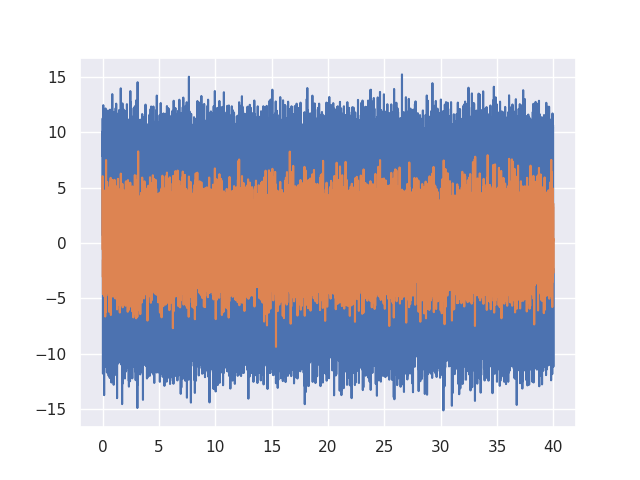

In [165]:
from scipy import signal

import matplotlib.pyplot as plt

rng = np.random.default_rng()

fs = 500

N = 20000

amp = 10

freq = 20

noise_power = 0.01 * fs / 2

time = np.arange(N) / fs

b, a = signal.butter(2, 0.25, 'low')

x = rng.normal(scale=np.sqrt(noise_power), size=time.shape)

y = signal.lfilter(b, a, x)

x += amp*np.sin(2*np.pi*freq*time)

y += rng.normal(scale=0.8*np.sqrt(noise_power), size=time.shape) + 0.3*amp*np.sin(2*np.pi*freq*time)


plt.figure()
plt.plot(time, x)
plt.plot(time, y)

#Cxy1, freq_closest = coherence1(x, y, fs=fs, freq=freq)
#Cxy, freq_closest, Cxy_all, freqs = coherence2(x, y, fs=fs, freq=freq)
freqs, Cxy_all = scipy.signal.coherence(x, y, fs=fs)


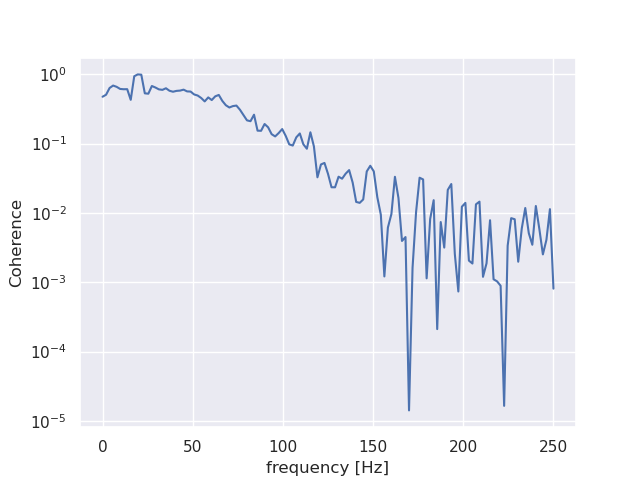

In [166]:
plt.figure()
plt.semilogy(freqs, Cxy_all)

plt.xlabel('frequency [Hz]')

plt.ylabel('Coherence')

plt.show()

In [3]:
def cross_spectral_decomp(event_windows, fs, freq_of_interest):
    n_events = event_windows.shape[0]
    n_chans = event_windows.shape[1]
    n_samps = event_windows.shape[2]
    
    half_idx = n_samps // 2
    
    # for each event, the window is divided in half so that coherent channels can be
    # quantified at two timepoints: early and late latency
    # return an average measure of the difference between the two timepoints
    subspace_angles = np.zeros((n_events,))
    for event_idx, event_window in enumerate(event_windows):
        comp_1 = np.zeros((2, n_chans))
        #c_mat_agg = np.zeros((n_events, n_chans, n_chans))
        # split win in half
        for win_range in range(2):
            c_mat = np.zeros((n_chans, n_chans))
            for chan1_idx, chan1_timeseries in enumerate(event_window):
                for chan2_idx, chan2_timeseries in enumerate(event_window):
                    if win_range == 0:
                        x = chan1_timeseries[:half_idx]
                        y = chan2_timeseries[:half_idx]
                    else:
                        x = chan1_timeseries[half_idx:]
                        y = chan2_timeseries[half_idx:]
                    # calc the cross-correlation at the freq of interest
                    #xcorr = np.sum(x[lag:] * y[:len(y) - lag])
                    freqs, Cxy = scipy.signal.coherence(x, y, nperseg=fs / freq_of_interest * 2)
                    freq_idx = np.argmin(np.abs(freqs - freq_of_interest))
                    Cxy_select = Cxy[freq_idx]
                    c_mat[chan1_idx, chan2_idx] = Cxy_select
            #c_mat = (c_mat + c_mat.T) / 2
            #c_mat_agg[event_idx, :, :] = c_mat
            U, s, Vh = np.linalg.svd(c_mat)
            comp_1[win_range, :] = Vh[0]
        # calculate angle between the 1st principle component unit vectors associated with each time point
        subspace_angles[event_idx] = np.arccos(np.sum(comp_1[0] * comp_1[1]))
    return subspace_angles.mean()


def spec_spat_events(epochs_pre_post, times):
    event_band = [9, 14]  # alpha band (Hz)
    thresh_FOM = 6.0  # factor-of-the-median threshold

    dt = times[1] - times[0]
    samp_freq = 1 / dt
    freqs = freqs = range(3, 40)
    
    t_win = 0.8  # time window; 800 ms
    n_win_samps = int((t_win / 2) // dt)
    #t_win_times = np.arange(0, t_win / 2 + dt, dt)
    #t_win_times = np.r_[-t_win_times[-1:0:-1], t_win_times[:]]
    iei_min = 0.8  # minimum distance between global spectral events (>=t_win); 800 ms
    
    sess_event_rate = list()
    sess_event_avg_freq = list()
    sess_dyn_alpha_shift = list()
    for epochs_data in epochs_pre_post:
        n_epochs = epochs_data.shape[0]
        n_channels = epochs_data.shape[1]
        n_times = epochs_data.shape[2]
        
        # z-score data across channels and time
        epochs_data -= epochs_data.mean(axis=(1, 2), keepdims=True)
        epochs_data /= epochs_data.std(axis=(1, 2), keepdims=True)
        
        # z-score data across time (caution: removes some spatial patterns!)
        #epochs_data -= epochs_data.mean(axis=(2,), keepdims=True)
        #epochs_data /= epochs_data.std(axis=(2,), keepdims=True)
        
        tfrs_chan_avg = np.zeros((n_epochs, len(freqs), n_times))
        for epoch_idx, epoch_data in enumerate(epochs_data):
            tfrs = se.tfr(epoch_data, freqs, samp_freq)
            # average TFR for this epoch across all channels
            tfrs_chan_avg[epoch_idx, :, :] = np.mean(tfrs, axis=(0,))
        
        # spectral events need to be found using a common thresh procedure across epochs
        spec_events_global = se.find_events(tfr=tfrs_chan_avg, times=times, freqs=freqs,
                                            event_band=event_band, threshold_FOM=3.5)

        # sanity check: plot "global" events for the 1st epoch
        #fig = se.plot_events(tfr=tfrs_chan_avg[0, :, :],
        #                     times=times,
        #                     freqs=freqs,
        #                     event_band=event_band,
        #                     spec_events=spec_events_global[0])

        print(f'Found {len(sum(spec_events_global, []))} global spectral events!!!')
        
        event_freqs = list()
        event_windows_agg = list()
        for epoch_events, epoch_data in zip(spec_events_global, epochs_data):

            event_times = np.array([event['Peak Time'] for event in epoch_events])

            event_times_no_overlap = list()
            for event_idx, event_time in enumerate(event_times):
                # crop off events that are too close to the beginning/end of epoch
                if (event_time - (n_win_samps * dt) < times[0] or
                    event_time + (n_win_samps * dt) > times[-1]):
                    continue
                    
                # don't include events that are shortly followed by another subsequent event
                
                if event_idx + 1 < len(event_times):
                    next_event_time = event_times[event_idx + 1]
                    if next_event_time - event_time < iei_min:
                        continue
                    
                event_times_no_overlap.append(event_time)

            if len(event_times_no_overlap) > 0:
                # get event peak frequencies to calculate average lag; concat to master list
                event_freqs += [event['Peak Frequency'] for event in epoch_events
                                if event['Peak Time'] in event_times_no_overlap]

                # capture the timecourse window at the current event across channels
                event_windows = np.zeros((len(event_times_no_overlap), n_channels, n_win_samps * 2 + 1))
                for event_idx, event_time in enumerate(event_times_no_overlap):
                    event_time_idx = np.nonzero(times == event_time)[0][0]
                    begin_idx = event_time_idx - n_win_samps
                    end_idx = event_time_idx + n_win_samps + 1
                    event_windows[event_idx, :, :] = epoch_data[:, begin_idx:end_idx]

                # append to aggregate list of events across all epochs in this session
                event_windows_agg.append(event_windows)
        
        event_rate = len(sum(spec_events_global, [])) / n_epochs
        
        # master array of all event windows across epochs
        event_windows_agg = np.concatenate(event_windows_agg)
        print(f'Kept {event_windows_agg.shape[0]} events for analysis!!!')
        print(f'shape: {event_windows_agg.shape}')
        
        if event_windows_agg.shape[0] == 0:
            raise ValueError("No events were found in this session. Consider decreasing "
                             "threshold_FOM when searching for spectral events!!!")
        
        # calculate lag as the time period associated with the avg peak frequency across events
        peak_freq_avg = np.mean(event_freqs)
        #lag = int(round(samp_freq / peak_freq_avg))  # time lag in number of samples (i.e., indices)
        
        print('Started: dynamic spatio-spectral event shift...')
        dyn_alph_shift = cross_spectral_decomp(event_windows_agg, samp_freq, peak_freq_avg)
        print('Finished: dynamic spatio-spectral event shift!!!')
        
        
        # compile session stats
        sess_event_rate.append(event_rate)
        sess_event_avg_freq.append(peak_freq_avg)
        sess_dyn_alpha_shift.append(dyn_alph_shift)
        
    event_rate_diff = sess_event_rate[1] - sess_event_rate[0]
    sess_event_avg_freq_diff = sess_event_avg_freq[1] - sess_event_avg_freq[0]
    sess_dyn_alpha_shift_diff = sess_dyn_alpha_shift[1] - sess_dyn_alpha_shift[0]
    

    return (event_rate_diff, sess_event_avg_freq_diff,
            sess_dyn_alpha_shift_diff)


def get_features(subj_id, series_num, data_dir):
    '''Main pipeline for computing all features for a given subject.'''
    epochs_pre_post, _, times = read_data(subj_id, series_num, data_dir)
    features = spec_spat_events(epochs_pre_post, times)
    return features

In [4]:
# set data directory
data_dir = '/gpfs/data/brainstorm-ws/data/'
data_type = 'TRAINING'

In [5]:
# read metadata from master list
fname_master = op.join(data_dir, data_type, data_type + '_Master List_All Series.csv')
master_keys = np.loadtxt(fname_master,  delimiter=',', max_rows=1, dtype=str)
master_keys[0] = 'TMSID'  # fix first key string
master_values = np.loadtxt(fname_master, delimiter=',', skiprows=1, dtype=str)
master_info = {key: master_values[:, master_keys == key].squeeze() for key in master_keys}

# get subject IDs for subject series with both pre-/post-TMS EEG recordings
subj_select = master_info['HasT1T2'] == '1'
subj_ids = master_info['TMSID'][subj_select]
n_subj_series = sum(subj_select)

In [6]:
# read metadata from demographics and clinical outcomes
fname_outcomes = op.join(data_dir, data_type, data_type + '_Demographics and Clinical Outcomes_All Series.csv')
outcomes_keys = np.loadtxt(fname_outcomes,  delimiter=',', max_rows=1, dtype=str)
outcomes_keys[0] = 'TMSID'  # fix first key string
outcomes_values = np.loadtxt(fname_outcomes, delimiter=',', skiprows=1, dtype=str)
outcome_info = {key: outcomes_values[:, outcomes_keys == key].squeeze() for key in outcomes_keys}

# get demographic and outcome data for each subject series
ages = outcome_info['AgeTMSstart'][subj_select].astype(int)
sexes = outcome_info['Sex'][subj_select].astype(int)
depression_histories = outcome_info['SevHxDep'][subj_select].astype(int)
symptoms_init = outcome_info['IDSSRtot.Ses1'][subj_select].astype(int)
responders = outcome_info['LastRespIDSSR'][subj_select].astype(int)

# get series number for each subject series
series_nums = outcome_info['Series'][subj_select].astype(int)

## Optional: pipeline test

In [7]:
# test analysis pipeline
data_type_dir = op.join(data_dir, data_type)
spec_spat_features = get_features(subj_ids[0], series_nums[0], data_type_dir)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_19014/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_19014/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 203 global spectral events!!!
Kept 91 events for analysis!!!
shape: (91, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 236 global spectral events!!!
Kept 109 events for analysis!!!
shape: (109, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


In [8]:
print(spec_spat_features)

(0.174565793347071, -0.07208387942332806, -0.016573115820086415)


In [9]:
# test analysis pipeline
data_type_dir = op.join(data_dir, data_type)
spec_spat_features = get_features(subj_ids[0], series_nums[0], data_type_dir)

# plot two successive post-event topographies in the pre-TMS session
_, epochs_info, _ = read_data(subj_ids[0], series_nums[0], data_type_dir)
fig, axes = plt.subplots(1, 2)
im_1, _ = plot_topomap(spec_spat_features[4][0][0], epochs_info, axes=axes[0],
                       vmin=-0.2, vmax=0.2, show=False)
plt.colorbar(im_1, ax=axes[0], fraction=0.05)
im_2, _ = plot_topomap(spec_spat_features[4][0][1], epochs_info, axes=axes[1],
                       vmin=-0.2, vmax=0.2, show=True)
plt.colorbar(im_2, ax=axes[1], fraction=0.05)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_134628/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_134628/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Found 203 global spectral events!!!
Kept 107 events for analysis!!!
shape: (107, 64, 299)
> /tmp/ipykernel_134628/2418046904.py(28)cross_spectral_decomp()
     26         U, s, Vh = np.linalg.svd(c_mat_agg.mean(axis=0))
     27         pdb.set_trace()
---> 28         comp_1.append(Vh[0])
     29 
     30     return comp_1[0], comp_1[1]

ipdb> Vh
array([[-0.02588516, -0.09475999, -0.15976416, ...,  0.16787171,
        -0.04988146,  0.04911718],
       [ 0.20051307,  0.19050289,  0.12749832, ..., -0.11746141,
        -0.12270424, -0.1242573 ],
       [ 0.22110282,  0.2134898 ,  0.15863421, ..., -0.01589887,
        -0.06105223,  0.07596627],
       ...,
       [ 0.00356599, -0.0206539 ,  0.0121998 , ..., -0.18590969,
         0.18044825, -0.00777287],
       [ 0.02974765, -0.002205  ,  0.00936559, ..., -0.52179642,
        -0.02897513, -0.00964158],
       [ 0.02522348, -0.02482114,  0.00144699, ..., -0.13465778,
        

BdbQuit: 

## Run main pipeline for feature extraction

In [7]:
# run spatio-spectral alpha coherence feature extraction
# use embarrassingly parallel loop across subject series to speed things up
n_jobs = 24
data_type_dir = op.join(data_dir, data_type)
out = Parallel(n_jobs=n_jobs)(delayed(get_features)(subj_ids[idx], series_nums[idx], data_type_dir)
                              for idx in range(n_subj_series))
feat_1, feat_2, feat_3 = zip(*out)

# convert to numpy arrays
feat_1 = np.array(feat_1)
feat_2 = np.array(feat_2)
feat_3 = np.array(feat_3)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T1/preprocessed/0091_Pre_Session1_Series4_Preprocessed.set...
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0246_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
80 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0116_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
68 matching events fou

Ready.
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
103 matching events found
Ready.
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0296_Pre_Session1_Series2_Preprocessed.set...
No baseline correction applied
0 projection items activated
No baseline correction applied
Ready.
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0296_Pre_Session1_Series3_Preprocessed.set...
Ready.
Not setting metadata
86 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0295_Post_Session1_Series2_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/br

No baseline correction applied
0 projection items activated
Ready.
Found 65 global spectral events!!!
Kept 37 events for analysis!!!
shape: (37, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 111 global spectral events!!!
Kept 53 events for analysis!!!
shape: (53, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0332_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0332_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 25 global spectral events!!!
Kept 17 events for analysis!

No baseline correction applied
0 projection items activated
Ready.
Found 152 global spectral events!!!
Kept 74 events for analysis!!!
shape: (74, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 118 global spectral events!!!
Kept 64 events for analysis!!!
shape: (64, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0356_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0356_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 53 global spectral events!!!
Kept 36 events for analysis

No baseline correction applied
0 projection items activated
Ready.
Found 203 global spectral events!!!
Kept 91 events for analysis!!!
shape: (91, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 236 global spectral events!!!
Kept 109 events for analysis!!!
shape: (109, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0373_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0373_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 148 global spectral events!!!
Kept 76 events for analy

No baseline correction applied
0 projection items activated
Ready.
Found 72 global spectral events!!!
Kept 43 events for analysis!!!
shape: (43, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 95 global spectral events!!!
Kept 56 events for analysis!!!
shape: (56, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0392_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0392_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 155 global spectral events!!!
Kept 65 events for analysis!

No baseline correction applied
0 projection items activated
Ready.
Found 103 global spectral events!!!
Kept 43 events for analysis!!!
shape: (43, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 93 global spectral events!!!
Kept 62 events for analysis!!!
shape: (62, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0419_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
115 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0419_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 2 global spectral events!!!
Kept 1 events for analysis!!

Ready.
Found 69 global spectral events!!!
Kept 42 events for analysis!!!
shape: (42, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 79 global spectral events!!!
Kept 44 events for analysis!!!
shape: (44, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0440_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0440_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 20 global spectral events!!!
Kept 15 events for analysis!!!
shape: (15, 64, 401)
Started: dynamic spatio-spectral eve

No baseline correction applied
0 projection items activated
Ready.
Found 51 global spectral events!!!
Kept 40 events for analysis!!!
shape: (40, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 52 global spectral events!!!
Kept 35 events for analysis!!!
shape: (35, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/9001_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/9001_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 123 global spectral events!!!
Kept 62 events for analysis!

/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 60 global spectral events!!!
Kept 38 events for analysis!!!
shape: (38, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 57 global spectral events!!!
Kept 25 events for analysis!!!
shape: (25, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 29 global spectral events!!!
Kept 22 events for analysis!!!
shape: (22, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 27 global spectral events!!!
Kept 19 events for analysis!!!
shape: (19, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 170 global spectral events!!!
Kept 80 events for analysis!!!
shape: (80, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 124 global spectral events!!!
Kept 74 events for analysis!!!
shape: (74, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 180 global spectral events!!!
Kept 76 events for analysis!!!
shape: (76, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 111 global spectral events!!!
Kept 57 events for analysis!!!
shape: (57, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 13 global spectral events!!!
Kept 12 events for analysis!!!
shape: (12, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 25 global spectral events!!!
Kept 18 events for analysis!!!
shape: (18, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 113 global spectral events!!!
Kept 67 events for analysis!!!
shape: (67, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 64 global spectral events!!!
Kept 43 events for analysis!!!
shape: (43, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 41 global spectral events!!!
Kept 26 events for analysis!!!
shape: (26, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 20 global spectral events!!!
Kept 14 events for analysis!!!
shape: (14, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 27 global spectral events!!!
Kept 20 events for analysis!!!
shape: (20, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 138 global spectral events!!!
Kept 70 events for analysis!!!
shape: (70, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 60 global spectral events!!!
Kept 43 events for analysis!!!
shape: (43, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 142 global spectral events!!!
Kept 57 events for analysis!!!
shape: (57, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 42 global spectral events!!!
Kept 32 events for analysis!!!
shape: (32, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 16 global spectral events!!!
Kept 13 events for analysis!!!
shape: (13, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 95 global spectral events!!!
Kept 54 events for analysis!!!
shape: (54, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 143 global spectral events!!!
Kept 64 events for analysis!!!
shape: (64, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 35 global spectral events!!!
Kept 25 events for analysis!!!
shape: (25, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 46 global spectral events!!!
Kept 31 events for analysis!!!
shape: (31, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 214 global spectral events!!!
Kept 76 events for analysis!!!
shape: (76, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 117 global spectral events!!!
Kept 64 events for analysis!!!
shape: (64, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 150 global spectral events!!!
Kept 86 events for analysis!!!
shape: (86, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 144 global spectral events!!!
Kept 64 events for analysis!!!
shape: (64, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 158 global spectral events!!!
Kept 79 events for analysis!!!
shape: (79, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 164 global spectral events!!!
Kept 77 events for analysis!!!
shape: (77, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 180 global spectral events!!!
Kept 80 events for analysis!!!
shape: (80, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 169 global spectral events!!!
Kept 77 events for analysis!!!
shape: (77, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 113 global spectral events!!!
Kept 71 events for analysis!!!
shape: (71, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 80 global spectral events!!!
Kept 56 events for analysis!!!
shape: (56, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 146 global spectral events!!!
Kept 64 events for analysis!!!
shape: (64, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 123 global spectral events!!!
Kept 70 events for analysis!!!
shape: (70, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 217 global spectral events!!!
Kept 82 events for analysis!!!
shape: (82, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 203 global spectral events!!!
Kept 85 events for analysis!!!
shape: (85, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 242 global spectral events!!!
Kept 119 events for analysis!!!
shape: (119, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 105 global spectral events!!!
Kept 69 events for analysis!!!
shape: (69, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

Found 199 global spectral events!!!
Kept 90 events for analysis!!!
shape: (90, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!
Found 196 global spectral events!!!
Kept 98 events for analysis!!!
shape: (98, 64, 401)
Started: dynamic spatio-spectral event shift...
Finished: dynamic spatio-spectral event shift!!!


/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_23992/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the f

## Try to visualize clusters and observe trends

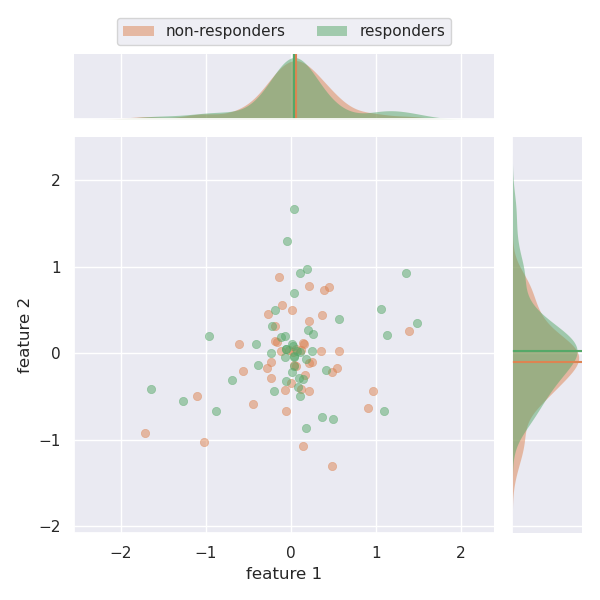

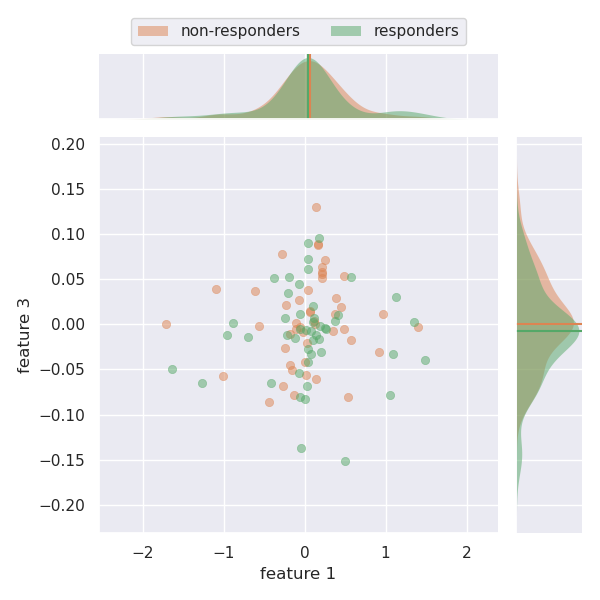

In [8]:
# plot 1st and 2nd features
#ax_labels = [r'$std(W_{sess_2})-std(W_{sess_1})$', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
ax_labels = ['feature 1', 'feature 2']
plot_features_scatter(x=feat_1, y=feat_2, responder_labels=responders, ax_labels=ax_labels)

# plot 1st and 3rd features
#ax_labels = [r'$\Delta$ cross-hemisphere beta event coherence', r'$\parallel W_{sess_2}-W_{sess_1}\parallel$']
ax_labels = ['feature 1', 'feature 3']
plot_features_scatter(x=feat_1, y=feat_3, responder_labels=responders, ax_labels=ax_labels)

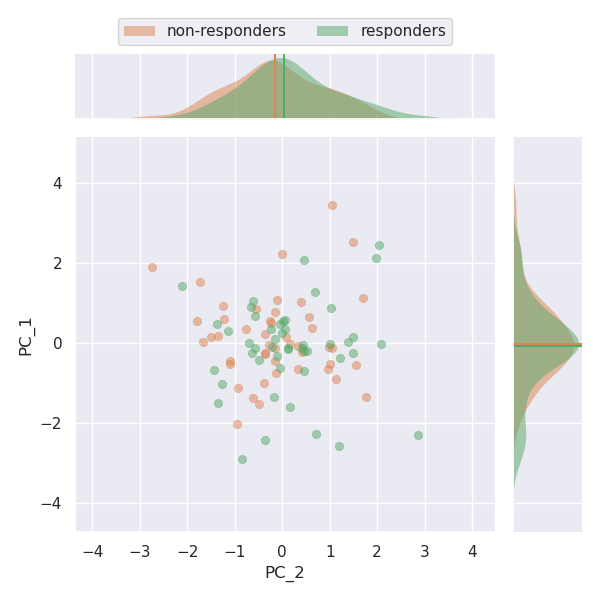

In [9]:
# PCA: see if the two data classes appear to be linearly separable
# answer: nope
X = np.c_[feat_1, feat_2, feat_3]
X = StandardScaler().fit_transform(X)
pca = PCA()
pca.fit(X)
pcs = pca.components_[:2, :]
X_pc = X @ pcs.T

ax_labels = ['PC_2', 'PC_1']
plot_features_scatter(x=X_pc[:, 1], y=X_pc[:, 0], responder_labels=responders, ax_labels=ax_labels)

## Train and validate SVM classifier
- first try omicient version (i.e., training data = testing data)
- then try with separate training and testing datasets, for demographic regressors only
- finally add EEG features

In [11]:
X = np.c_[feat_1, feat_2, feat_3, feat_4, ages, sexes, depression_histories, symptoms_init]
X = StandardScaler().fit_transform(X)
svm_cls = svm.SVC(kernel='rbf')
svm_cls.fit(X, responders)
svm_cls.score(X, responders)

0.8

Found 27 global spectral events!!!
Kept 22 events for analysis!!!
shape: (22, 64, 299)
Found 138 global spectral events!!!
Kept 80 events for analysis!!!
shape: (80, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 60 global spectral events!!!
Kept 46 events for analysis!!!
shape: (46, 64, 299)
Found 142 global spectral events!!!
Kept 73 events for analysis!!!
shape: (73, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


Found 158 global spectral events!!!
Kept 91 events for analysis!!!
shape: (91, 64, 299)
Found 164 global spectral events!!!
Kept 86 events for analysis!!!
shape: (86, 64, 299)


/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_52587/24770785.py:13: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.


In [12]:
n_perm = 1000
training_set_ratio = 0.7

n_set = n_subj_series
n_training_set = int(np.round(training_set_ratio * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = np.c_[ages[train_idxs],
                    sexes[train_idxs],
                    depression_histories[train_idxs],
                    symptoms_init[train_idxs]]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='rbf')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = np.c_[ages[test_idxs],
                   sexes[test_idxs],
                   depression_histories[test_idxs],
                   symptoms_init[test_idxs]]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.5027586206896552


In [13]:
n_perm = 1000
training_set_ratio = 0.7

n_set = n_subj_series
n_training_set = int(np.round(training_set_ratio * n_set))
n_test_set = int(n_set - n_training_set)

accuracy_scores = np.zeros((n_perm,))
for perm_idx in range(n_perm):
    
    set_idxs = np.arange(n_set)
    np.random.shuffle(set_idxs)
    train_idxs = set_idxs[:n_training_set]
    test_idxs = set_idxs[n_training_set:]
    
    # fit to training set
    X_train = np.c_[feat_1[train_idxs],
                    feat_2[train_idxs],
                    feat_3[train_idxs]]
    std_scaler = StandardScaler().fit(X_train)
    X_train = std_scaler.transform(X_train)
    Y_train = responders[train_idxs]
    svm_cls = svm.SVC(kernel='linear')
    svm_cls.fit(X_train, Y_train)
    
    # validate on test set
    X_test = np.c_[feat_1[test_idxs],
                   feat_2[test_idxs],
                   feat_3[test_idxs]]
    X_test = std_scaler.transform(X_test) 
    Y_test = responders[test_idxs]
    accuracy_scores[perm_idx] = svm_cls.score(X_test, Y_test)

print(f'Mean accuracy: {np.mean(accuracy_scores)}')

Mean accuracy: 0.46251724137931033
